###Atividade 1 - ML APlicado 2

Descrição da atividade: 
* Escolher um classificador do tipo NB (apropriado)
* Utilizar o dataset Congressional Voting Records
(https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)
>* Descrever os dados com as estatísticas principais 
>* Conversão de features
>* Tratamento das missing features
>* Train-Test split
* Criar um Jupyter Notebook (colab.research, kaggle, etc.)
* Mostrar o desempenho com várias métricas (confusion matrix, AUC, ROC, etc.)

####1 - Imports

In [ ]:
import numpy as np
import pandas as pd
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


####2 - Carregando o Dataset

In [ ]:
url= 'http://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

features = ['class-name', 'handicapped-infants','water-project-cost-sharing','adoption-of-the-budget-resolution','physician-fee-freeze','el-salvador-aid','religious-groups-in-schools','anti-satellite-test-ban','aid-to-nicaraguan-contras','mx-missile','immigration', 'synfuels-corporation-cutback', 'education-spending', 'superfund-right-to-sue','crime','duty-free-exports','export-administration-act-south-africa']
target = features[0] #atributo target
attrs = features[1:len(features)] #demais atributos

df_original = pd.read_csv(url, names=features, sep=",")

df_original.head()

,class-name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [ ]:
df_original.shape

(435, 17)

In [ ]:
df_original.describe()

,class-name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435
unique,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


####3 - Verificação de Dados Faltantes

In [ ]:
df_original.dtypes

class-name                                object
handicapped-infants                       object
water-project-cost-sharing                object
adoption-of-the-budget-resolution         object
physician-fee-freeze                      object
el-salvador-aid                           object
religious-groups-in-schools               object
anti-satellite-test-ban                   object
aid-to-nicaraguan-contras                 object
mx-missile                                object
immigration                               object
synfuels-corporation-cutback              object
education-spending                        object
superfund-right-to-sue                    object
crime                                     object
duty-free-exports                         object
export-administration-act-south-africa    object
dtype: object

In [ ]:
df_original.isnull( ).sum()

class-name                                0
handicapped-infants                       0
water-project-cost-sharing                0
adoption-of-the-budget-resolution         0
physician-fee-freeze                      0
el-salvador-aid                           0
religious-groups-in-schools               0
anti-satellite-test-ban                   0
aid-to-nicaraguan-contras                 0
mx-missile                                0
immigration                               0
synfuels-corporation-cutback              0
education-spending                        0
superfund-right-to-sue                    0
crime                                     0
duty-free-exports                         0
export-administration-act-south-africa    0
dtype: int64

É de conhecimento que as features apresentam 3 classes possíveis: "n", "y" e "?".

"?" não foi considerado como uma representação para valor faltante (NaN), visto que, na documentação do dataset, esta classe representa aqueles que estavam presentes para votação (em "n" ou "y"), mas escolheram não se manifestar. 

####4 - Distribuição dos Rótulos (atributo *target*)

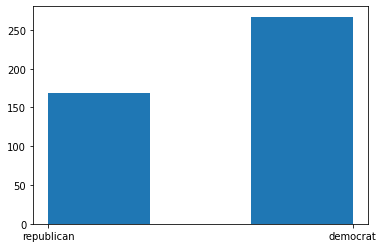

In [ ]:
plt.figure()
histograma_dfOriginal = plt.hist(df_original['class-name'], bins=3) #histograma
plt.show()

In [ ]:
histograma_dfOriginal

(array([168.,   0., 267.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

É observável que há quase 100 registros de diferença entre as classes do atributo target. Esta diferença é tratada na seção 9, de Treinamento do Modelo.

####5 - Análise de *Features*

In [ ]:
df = df_original.copy()

In [ ]:
def count_individual_feattures(df, columns):
    for var in columns:
        print(df[var].value_counts(), '\n')

count_individual_feattures(df, features) #features contém TODAS as colunas

democrat      267
republican    168
Name: class-name, dtype: int64 

n    236
y    187
?     12
Name: handicapped-infants, dtype: int64 

y    195
n    192
?     48
Name: water-project-cost-sharing, dtype: int64 

y    253
n    171
?     11
Name: adoption-of-the-budget-resolution, dtype: int64 

n    247
y    177
?     11
Name: physician-fee-freeze, dtype: int64 

y    212
n    208
?     15
Name: el-salvador-aid, dtype: int64 

y    272
n    152
?     11
Name: religious-groups-in-schools, dtype: int64 

y    239
n    182
?     14
Name: anti-satellite-test-ban, dtype: int64 

y    242
n    178
?     15
Name: aid-to-nicaraguan-contras, dtype: int64 

y    207
n    206
?     22
Name: mx-missile, dtype: int64 

y    216
n    212
?      7
Name: immigration, dtype: int64 

n    264
y    150
?     21
Name: synfuels-corporation-cutback, dtype: int64 

n    233
y    171
?     31
Name: education-spending, dtype: int64 

y    209
n    201
?     25
Name: superfund-right-to-sue, dtype: int64 

y   

#####5.1 - Verificação das contagens por classes

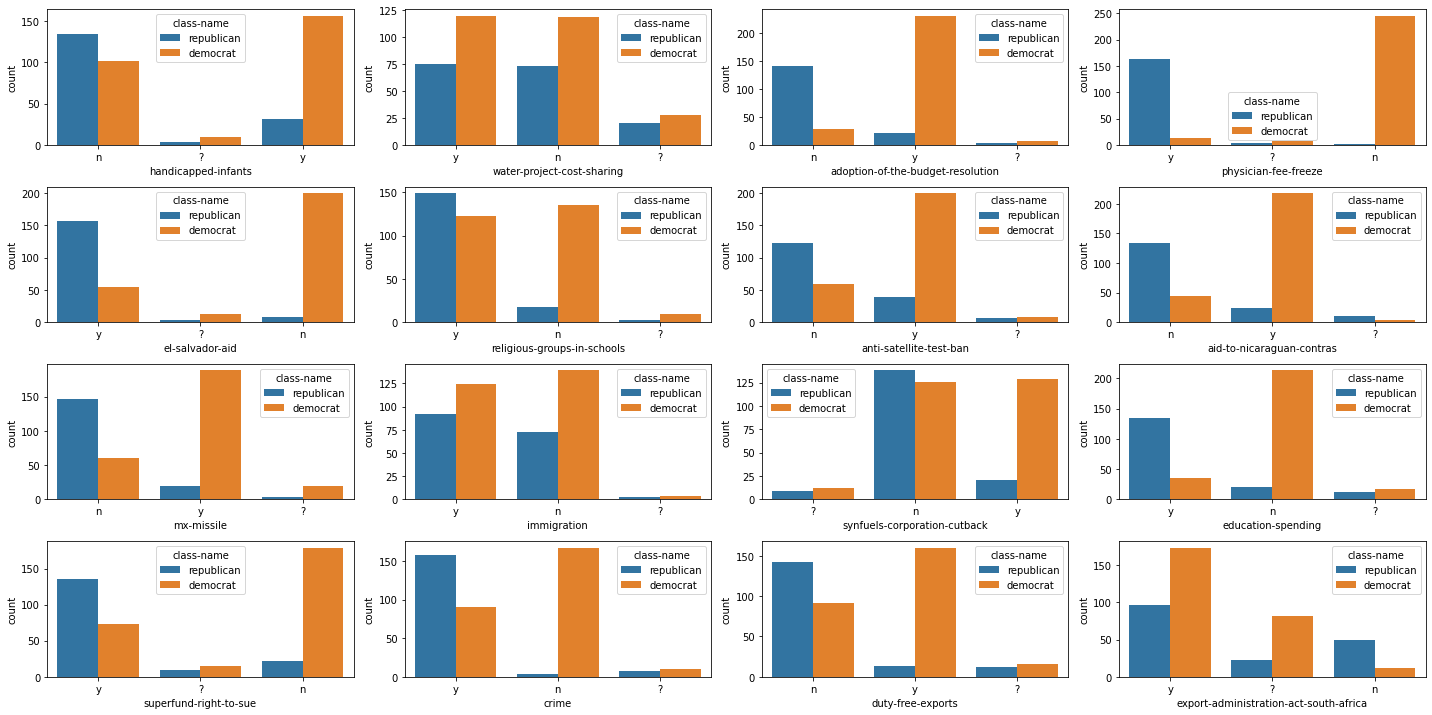

In [ ]:
def count_plot(df, columns):
  plt.figure(figsize = (20, 10))
  for indx, var in enumerate(columns):
    plt.subplot(4, 4, (indx + 1))
    sns.countplot(x = var, hue = df[target], data = df)
  plt.tight_layout()

count_plot(df, attrs)

####6 - Encoding dos atributos

#####6.1 - Encoding de *Features*

In [ ]:
#Geração do encoding (formato de series) de dada series especificada
# pelos parâmetros recebidos: 1 dataframe, 1 string (nome da coluna).

def encode_object_att(_df, _column):
  label_encoder = LabelEncoder()
  serie_aux = label_encoder.fit_transform(list(_df[_column].values))
  return serie_aux

In [ ]:
#Enconding de features

for coluna in attrs:
  df[coluna] = encode_object_att(df, coluna)

In [ ]:
df[attrs].head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2


In [ ]:
df_original[attrs].head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [ ]:
for col in attrs:
  print("Valores únicos na coluna ",col)
  print(df[col].unique())

Valores únicos na coluna  handicapped-infants
[1 0 2]
Valores únicos na coluna  water-project-cost-sharing
[2 1 0]
Valores únicos na coluna  adoption-of-the-budget-resolution
[1 2 0]
Valores únicos na coluna  physician-fee-freeze
[2 0 1]
Valores únicos na coluna  el-salvador-aid
[2 0 1]
Valores únicos na coluna  religious-groups-in-schools
[2 1 0]
Valores únicos na coluna  anti-satellite-test-ban
[1 2 0]
Valores únicos na coluna  aid-to-nicaraguan-contras
[1 2 0]
Valores únicos na coluna  mx-missile
[1 2 0]
Valores únicos na coluna  immigration
[2 1 0]
Valores únicos na coluna  synfuels-corporation-cutback
[0 1 2]
Valores únicos na coluna  education-spending
[2 1 0]
Valores únicos na coluna  superfund-right-to-sue
[2 0 1]
Valores únicos na coluna  crime
[2 1 0]
Valores únicos na coluna  duty-free-exports
[1 2 0]
Valores únicos na coluna  export-administration-act-south-africa
[2 0 1]


O Label Encoder generalizou os novos labels para todo o dataset:
* "?" = 0;
* "n" = 1;
* "y" = 2.

#####6.2 - Encoding do atributo *target*

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df[target])
#print(y)
print(label_encoder.classes_)

['democrat' 'republican']


####7 - Análise de Independência dos Atributos

In [ ]:
X = df.loc[:,df.columns[1]:df.columns[len(df.columns)-1]].values

In [ ]:
X

array([[1, 2, 1, ..., 2, 1, 2],
       [1, 2, 1, ..., 2, 1, 0],
       [0, 2, 2, ..., 2, 1, 1],
       ...,
       [1, 0, 1, ..., 2, 1, 2],
       [1, 1, 1, ..., 2, 1, 2],
       [1, 2, 1, ..., 2, 0, 1]])

In [ ]:
n = X.shape[1]

for var1 in range(n):
  for var2 in range(var1+1,n):
    MI = mutual_info_score(X[:,var1], X[:,var2])
    #print(MI)
    if MI > 0.5:
      print(MI)

Todas as variáveis são independentes.

####8 - Separação das Amostras de Treino e Teste

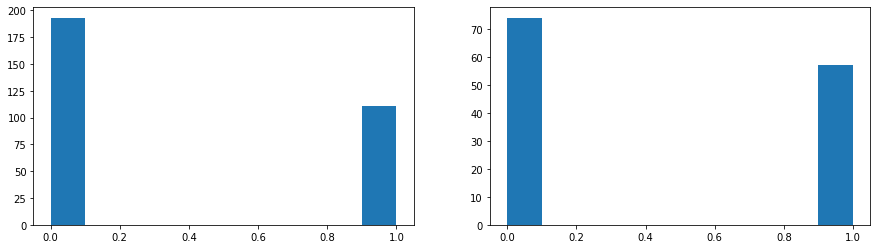

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=143)

# depois da separação podemos conferir a distribuição de classes nos dois novos conjuntos
# a mesma distribuição de rótulos é garantida pelo sklearn
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(y_train)
plt.subplot(1,2,2)
plt.hist(y_test)
plt.show()

Como pode ser visto acima, há uma desigualdade considerável entre as quantias de registros das classes do atributo target.

Portanto, foi considerada a estratégia de diminuição aleatória de amostras (Random Undersample) da classe majoritária:

In [ ]:
#Definindo estratégia de underSample
undersample = RandomUnderSampler(sampling_strategy='majority') 
#majority, pois o atributo target só tem duas classes

X_samp, y_samp = undersample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
np.unique(y_samp, return_counts=True)

(array([0, 1]), array([168, 168]))

Na tupla acima, podemos verificar que as classes `0` e `1` possuem as mesmas quantias de registros: 168. Abaixo verifica-se graficamente a nova distribuição:

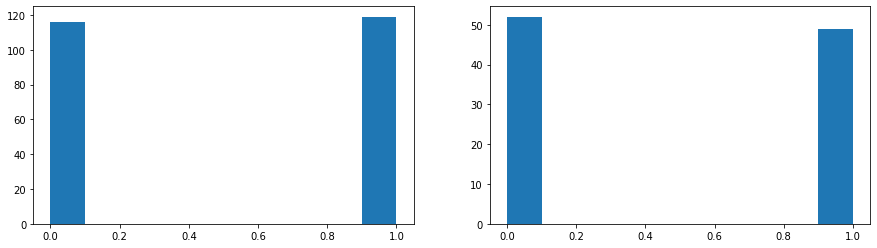

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size=0.3, random_state=143)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(y_train)
plt.subplot(1,2,2)
plt.hist(y_test)
plt.show()

####9 - Treinamento do Modelo

In [ ]:
clf = CategoricalNB()
clf.fit(X_train, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

####10 - Aplicação do Modelo

In [ ]:
y_pred_clf = clf.predict(X_test)
y_prob_pred_clf = clf.predict_proba(X_test)

count_misclassified = (y_test != y_pred_clf).sum()

print('Amostras classificadas INCORRETAMENTE: {}'.format(count_misclassified))

Amostras classificadas INCORRETAMENTE: 7


In [ ]:
print(X_test[0,:])
print(y_prob_pred_clf[0,:])
y_prob_pred_clf[0]

[2 2 2 0 1 1 1 2 1 1 2 0 1 1 2 2]
[9.99999073e-01 9.26539617e-07]


array([9.99999073e-01, 9.26539617e-07])

              precision    recall  f1-score   support

  republican       0.92      0.94      0.93        52
    democrat       0.94      0.92      0.93        49

    accuracy                           0.93       101
   macro avg       0.93      0.93      0.93       101
weighted avg       0.93      0.93      0.93       101



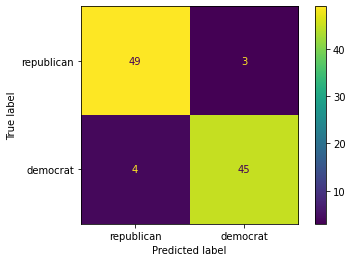

In [ ]:
print(classification_report(y_test, y_pred_clf, target_names=['republican', 'democrat']))

plot_confusion_matrix(clf, X_test, y_test, display_labels=['republican', 'democrat'])